# CNN Exercise 1: Rebuilding LeNet

Created by Cedric Ewen in 2023

Credits to Bogdan Wiederspan who inspired this exercise with his exercice from the last years deep learning school and to [this blog post](https://medium.com/@nutanbhogendrasharma/pytorch-convolutional-neural-network-with-mnist-dataset-4e8a4265e118) that gave a good baseline for the exercise.
Thanks to Github Copilot for writing the description of this exercise.

# History
Machine learning is a topic that is researched for quite a long time. Biggest problem in the past was the lack of computational ressources. Especially image recognition was terrible in this department, since the analyzation of pictures needed huge feed-forward-networks (bad scaling of parameter numbers).

Feed-forward-networks are a bad choice to analyze images, since the learned mapping is not translation-invariant. This means, that the network could not recognize for example a deer, when the deer was not centered.

LeNet-5 was one of the earliest convolutional neural networks and promoted the development of deep learning. The main benefit of convolutional networks is their invariance in translation. The other benefit of this approach is the reduction of learnable parameters by introduction of convolutions.

We will recreate the LeNet-5 network to train a model on MNIST dataset!

In [1]:
# basic imports
import torch
import matplotlib.pyplot as plt

In [2]:
# device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# The dataset

The MNIST (Modified National Institute of Standards and Technology database) dataset is a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau. Each image is labeled with the digit it represents. This set has been studied so much that it is often called the "Hello World" of Machine Learning. Whenever people come up with a new classification algorithm they are curious to see how it will perform on MNIST, and anyone who learns Machine Learning tackles this dataset sooner or later.

PyTorch provides a number of datasets in torchvison.datasets. We will download the MNIST dataset from there. The following code downloads the MNIST dataset, and creates a training and test dataset. The training dataset contains 60,000 images and the test dataset contains 10,000 images. Each image is a 28x28 grayscale image.

In [3]:
from torchvision import datasets
from torchvision.transforms import ToTensor
train_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = True,
)
test_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform = ToTensor()
)

100%|███████████████████████████| 9912422/9912422 [00:00<00:00, 28991167.34it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|███████████████████████████████| 28881/28881 [00:00<00:00, 42986406.61it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw




100%|███████████████████████████| 1648877/1648877 [00:00<00:00, 10023481.34it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████████████████████████████| 4542/4542 [00:00<00:00, 7045313.89it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



It is important to first get a feeling for the data. Therefore, we will first plot some of the images and their corresponding labels.

We also have a look on the shape of the data. The shape of the data is important for the design of the network. In the following cell, one can see that the shape is (60000, 28, 28). This means that we have 60000 images of size 28x28 pixels. The images are grayscale, meaning that they have only one color channel. If the images were RGB images, the shape would be (60000, 28, 28, 3).

In [4]:
print(f"Shape of training data: {train_data.data.size()}")
print(f"Shape of test data: {test_data.data.size()}")

Shape of training data: torch.Size([60000, 28, 28])
Shape of test data: torch.Size([10000, 28, 28])


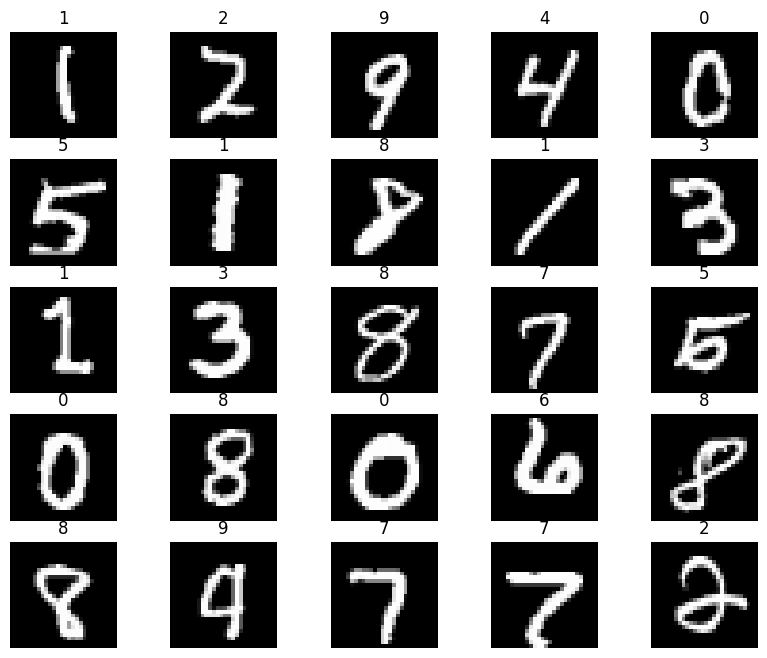

In [5]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

During training, we usually want to pass samples in 'minibatches', so small subsets of the training dataset, instead of passing all the training data at once. This is because passing all the training data through the network at once is computationally expensive, and it is also more difficult for the network to learn from all the training data at once. The number of samples in a minibatch is called the 'batch size'. The batch size is a hyperparameter that we can tune to make the network learn better. The batch size is usually a power of 2, e.g. 32, 64, 128, 256, 512, etc. to optimally utilize the hardware. In this exercise, we will use a batch size of 64.

In pytorch, a dataloader is an object that can be used to pass minibatches of data to the network. We can create a dataloader from a dataset object. The dataloader will automatically split the dataset into minibatches of the specified batch size. We can then iterate over the dataloader to get minibatches of data. The dataloader will automatically shuffle the data at the start of each epoch (an epoch is a full pass through the training data).

In [6]:
from torch.utils.data import DataLoader
loaders = {
    'train' : torch.utils.data.DataLoader(train_data,
                                          batch_size=64,
                                          shuffle=True,
                                          num_workers=1),

    'test'  : torch.utils.data.DataLoader(test_data,
                                          batch_size=64,
                                          shuffle=True,
                                          num_workers=1),
}

# The Architecture

We will now recreate one of the first convolutional neural networks, LeNet-5, which was introduced by Yann LeCun et al. in 1998. This network was used to classify handwritten digits of the MNIST dataset. The network consists of two convolutional layers, two pooling layers and three fully connected layers. The network architecture is shown below.
![image.png](attachment:image.png)
On the right, we see a much more advanced version of the LeNet-5, called AlexNet. Its quite interesting how similar, but yet so different they are.
AlexNet is much more advanced than the plain old LeNet.

Could you think of some reasons why:
- they changed all sigmoid functions to ReLu
- they changed the Pooling from average to max
- they use 3 conv-layers with small window size insted of one with bigger kernel size


In general Conv-networks can be separated into 2 blocks:
- conv-part (filters)
- fully connected network

In the convolutional-part of the network filters are trained to detect different propeties. They workout the different features of the image. These processed information are then used as input of a fully connected network to classify the input.

## Build LeNet-5 with PyTorch:
Lets build the model. We start with a Python class that inherits from nn.Module. In the init function we define the layers of the network. In the forward function we define the forward pass of the network.

A list of possible layers can be found [here](https://pytorch.org/docs/stable/nn.html).

By looking at the Picture of LeNet we need a ***Linear Layer, a Pooling Layer*** and atleast some kind of ***ConvND*** layer (which Dimension? Remember your input data shape!).


To help you a little in building the network the start and end is already given. Compare the code of the layer with the Image of LeNet to get a better understand what they do!

Try to answer the following questions while learning how to use PyTorch. PyTorch error messanges help you to understand whats happening, but also the ```print(model)``` and the ```torchsummary.summary``` commands.
- Which properties do the layer types have and what do they do?
- Why do we flatten the output?
- What is the shape after flatten?
- What work is done by the dense layers?
- Why do we use a softmax activation function at the end?
- What is the sum of the softmax function outputs?
- Where do the weights come from? How can one calculate the number of weights in a layer?

In [7]:
import torch.nn as nn
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # define the layers
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=6,
                kernel_size=5,
                stride=1,
                padding=2,
            ),
            nn.Sigmoid(),
        )
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=6,
                out_channels=16,
                kernel_size=5,
                stride=1,
                padding=0,
            ),
            nn.Sigmoid(),
        )
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        # fully connected network, output 10 classes
        self.out = nn.Sequential(
            nn.Linear(400, 120),
            nn.Sigmoid(),
            nn.Linear(120, 84),
            nn.Sigmoid(),
            nn.Linear(84, 10),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        # flatten the output of conv2 to (batch_size, 28x28)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output

In [8]:
cnn = CNN()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Sigmoid()
  )
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): Sigmoid()
  )
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (out): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=84, out_features=10, bias=True)
    (5): Softmax(dim=-1)
  )
)


In [9]:
from torchsummary import summary
summary(cnn, (1, 28, 28), batch_size=64, device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [64, 6, 28, 28]             156
           Sigmoid-2            [64, 6, 28, 28]               0
         AvgPool2d-3            [64, 6, 14, 14]               0
            Conv2d-4           [64, 16, 10, 10]           2,416
           Sigmoid-5           [64, 16, 10, 10]               0
         AvgPool2d-6             [64, 16, 5, 5]               0
            Linear-7                  [64, 120]          48,120
           Sigmoid-8                  [64, 120]               0
            Linear-9                   [64, 84]          10,164
          Sigmoid-10                   [64, 84]               0
           Linear-11                   [64, 10]             850
          Softmax-12                   [64, 10]               0
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
---------------------------------

# Training

Now that we have the model, we can train it. We will use the Adam optimizer, which is a popular optimizer along with SGD (Stochastic Gradient Descent). We will also use the cross entropy loss function, which is the most common loss function for classification problems.

In [10]:
loss_func = nn.CrossEntropyLoss()
loss_func

CrossEntropyLoss()

In [11]:
# move model to GPU
cnn = cnn.to(device)

In [12]:
from torch import optim
optimizer = optim.Adam(cnn.parameters(), lr = 0.01)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)

Now we can implement a train method that will train the model. It takes as input the number of epochs, the model and the dataloader.

In [13]:
from tqdm import tqdm

def train(num_epochs, cnn, loaders):

    # Train the model
    cnn.train()
    for epoch in tqdm(range(num_epochs)):
        for i, (images, labels) in enumerate(loaders['train']):
            # move data to GPU
            images = images.to(device)
            labels = labels.to(device)
            # run model
            output = cnn(images)
            # compute loss function
            loss = loss_func(output, labels)
            # clear gradients for this training step
            optimizer.zero_grad()
            # backpropagation, compute gradients
            loss.backward()
            # apply update
            optimizer.step()

num_epochs = 10
train(num_epochs, cnn, loaders)

100%|███████████████████████████████████████████| 10/10 [01:05<00:00,  6.53s/it]


To check the performance of our network, we can run a prediction on our test data and check if the events are categorised correctly.

In [14]:
def test(cnn, loaders):
    test_prediction = torch.tensor([], device=device)
    test_label = torch.tensor([], device=device)
    # Test the model
    cnn.eval()
    with torch.no_grad():
        for images, labels in loaders['test']:
            images = images.to(device)
            labels = labels.to(device)
            test_output = cnn(images)
            pred_labels = torch.max(test_output, dim=1)[1]
            test_prediction = torch.concatenate((test_prediction,pred_labels))
            test_label = torch.concatenate((test_label,labels))
    return test_label.cpu(), test_prediction.cpu()

test_label, test_prediction = test(cnn, loaders)

In [15]:
for i, label in enumerate(test_label[:10]):
    print(f"Predicted label: {test_prediction[i]}, True label: {label}; Prediction is {'correct' if test_prediction[i] == label else 'incorrect'}")

Predicted label: 3.0, True label: 3.0; Prediction is correct
Predicted label: 5.0, True label: 3.0; Prediction is incorrect
Predicted label: 9.0, True label: 9.0; Prediction is correct
Predicted label: 8.0, True label: 8.0; Prediction is correct
Predicted label: 8.0, True label: 8.0; Prediction is correct
Predicted label: 3.0, True label: 3.0; Prediction is correct
Predicted label: 0.0, True label: 0.0; Prediction is correct
Predicted label: 7.0, True label: 7.0; Prediction is correct
Predicted label: 7.0, True label: 7.0; Prediction is correct
Predicted label: 1.0, True label: 1.0; Prediction is correct


We can use [sklearn.metrics] to take a more detailed look into the performance, e.g. via creating a confusion matrix.

[sklearn.metrics]: https://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics

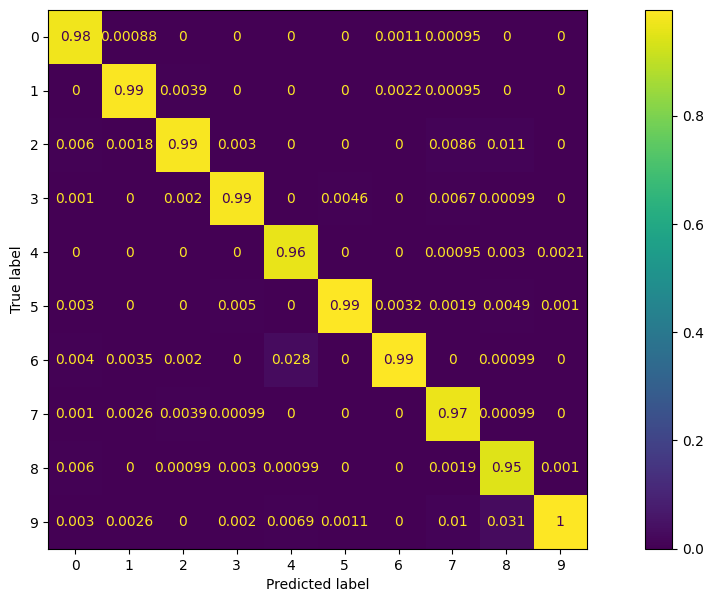

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Create confusion matrix and normalizes it over predicted (columns)
confusion = confusion_matrix(test_label.numpy(), test_prediction.numpy(), normalize='pred')

# Create a plot of the confusion matrix
fig, ax = plt.subplots(figsize=(15, 7))
ConfusionMatrixDisplay(confusion).plot(ax=ax)
plt.show()

How can one improve the networks scores? We can add more Conv oder Dense layers to strenghten one part of your network! More Dense layers will increase your classification power, while more Conv layers will increase your propety filter power.
We might also want to prevent overtraining, e.g. via including some Dropout layers.